<h1><center>Machine Learning and Asset Pricing Models</center></h1>
<h2><center>Yujia Ren yxr126@case.edu</center></h2>

Statistical explanations are from [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) website.

<h1>Problem definition</h1>

In this project, I plan to use machine learning to construct an asset pricing model. In the model, I will have a set of variables to capture the features of stock returns. The problem naturally is categorized into two sub-tasks: the choice of the most important features and the prediction of the stock returns. We will separate our data into the training and testing sets, which are totally separated in the task. We will first train the data using all input variables available, then we select the most important k variables based on the prediction. Then we truncate the number variables to k to redo the prediction. To improve the robustness of our method, we will test our full-variable and truncated-variable models using the testing set, and apply four-fold cross-validation to run the model multiple times. Besides, according to the reference (Gu et al., 2019), we may use a new methodology here, which includes the statistical model describing the risk premium, an  objective function to estimate model parameters and computational algorithms. The methods we will use include but not limited to simple linear regression, regularized linear regressions (e.g. ridge regression), decision tree regression and neural networks. For input space dimension reduction, we can use recursive feature elimination (RFE) and principal component regression (PCR). All of the estimates share the basic goal of minimum MSE. The final result of this project includes the regression accuracy, the most important input variables of each method.

<h1>Modules and functions</h1>

In [2]:
# import modules
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
%matplotlib inline

### 2.1 Define functions

In [2]:
def generate_data(sic2_number=1):
    '''
    A function to read the stock data and output standardized x and y
    args: sic2 stock code (i.e 1 means agricultural stocks)
    return: standardized x, y and column names
    '''
    # import feature and returns
    df = pd.read_csv(r'../yujia_data/data/project_machine.csv')
    column_names_old = list(df)
    df = df[df['sic2']==sic2_number]
    df = df.fillna(0)
    #df = df.dropna(axis=1)
    not_include = ['RET','DATE', 'permno', 'sic2', 'gvkey', 'fyear', 'datadate',
                   'rdq', 'ewret', 'DLRET', 'DLSTCD']
    x = df.drop(not_include, axis=1)
    column_names = [e for e in column_names_old if e not in not_include] 
    y = df['RET']
    
    # standardize the data
    
    x = StandardScaler().fit_transform(x)
    y = y.values.reshape(-1,1)
    y = StandardScaler().fit_transform(y).squeeze()

    return x, y, column_names

### 2.2 Ordinary least squares regression
The following are a set of methods intended for regression in which the target value is expected to be a linear combination of the features. In mathematical notation, if $\hat{y}$ is the predicted value.

$$
\begin{aligned}
\hat{y}(w, x) = w_0 + w_1 x_1 + ... + w_p x_p
\end{aligned}
\\
$$

Across the module, we designate the vector $w = (w_1,
..., w_p)$ as <code>coef_</code> and $w_0$ as <code>intercept_</code>.

Ordinary Least Squares fits a linear model with coefficients $w = (w_1, ..., w_p)$ to to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Mathematically it solves a problem of the form:
$$
\begin{aligned}
\min_{w} || X w - y||_2^2
\end{aligned}
$$

In [3]:
def ols(x_train, x_test, y_train, y_test, alpha=None):
    '''
    A function to do ols regression
    args: x train, x test, y train, y test, dummpy alpha
    return: y pred, linear coefficients
    '''
    clf = LinearRegression()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    coef = clf.coef_.squeeze()
    return y_pred, coef

### 2.3 Lasso regression
The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. For this reason Lasso and its variants are fundamental to the field of compressed sensing. Under certain conditions, it can recover the exact set of non-zero coefficients.

Mathematically, it consists of a linear model with an added regularization term. The objective function to minimize is:

$$
\begin{aligned}
\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}
\end{aligned}
$$

The lasso estimate thus solves the minimization of the least-squares penalty with $\alpha ||w||_1$ added, where $\alpha$ is a constant and $||w||_1$ is the $\ell_1$-norm of the coefficient vector.

In [4]:
def lasso(x_train, x_test, y_train, y_test, alpha=0.0001):
    '''
    A function to do lasso regression
    args: x train, x test, y train, y test, lasso alpha
    return: y pred, linear coefficients
    '''
    clf = Lasso(alpha=alpha, max_iter=10000)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    coef = clf.coef_.squeeze()
    return y_pred, coef

### 2.4 Ridge regression

Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares:

$$
\begin{aligned}
\min_{w} || X w - y||_2^2 + \alpha ||w||_2^2
\end{aligned}
$$

The complexity parameter $\alpha \geq 0$ controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity.

In [5]:
def ridge(x_train, x_test, y_train, y_test, alpha=0.2):
    '''
    A function to do ridge regression
    args: x train, x test, y train, y test, ridge alpha
    return: y pred, linear coefficients
    '''
    clf = Ridge(alpha=alpha, max_iter=10000)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    coef = clf.coef_.squeeze()
    return y_pred, coef

### 2.5 Bayesian ridge regression

Bayesian regression techniques can be used to include regularization parameters in the estimation procedure: the regularization parameter is not set in a hard sense but tuned to the data at hand.

This can be done by introducing uninformative priors over the hyper parameters of the model. The $\ell_2$ regularization used in Ridge regression and classification is equivalent to finding a maximum a posteriori estimation under a Gaussian prior over the coefficients  with precision $\lambda^{-1}$. Instead of setting <code>lambda</code> manually, it is possible to treat it as a random variable to be estimated from the data.
    
To obtain a fully probabilistic model, the output $y$ is assumed to be Gaussian distributed around $Xw$:

$$
\begin{aligned}
p(y|X,w,\alpha) = \mathcal{N}(y|X w,\alpha)
\end{aligned}
$$

where $\alpha$ is again treated as a random variable that is to be estimated from the data.

The advantages of Bayesian Regression are:
* It adapts to the data at hand.
* It can be used to include regularization parameters in the estimation procedure.

The disadvantages of Bayesian regression include:
* Inference of the model can be time consuming.

BayesianRidge estimates a probabilistic model of the regression problem as described above. The prior for the coefficient  is given by a spherical Gaussian:

$$
\begin{aligned}
p(w|\lambda) =
\mathcal{N}(w|0,\lambda^{-1}\mathbf{I}_{p})
\end{aligned}
$$

The priors over $\alpha$ and $\lambda$ are chosen to be gamma distributions, the conjugate prior for the precision of the Gaussian. The resulting model is called <em>Bayesian Ridge Regression</em>, and is similar to the classical Ridge.

The parameters $w$, $\alpha$ and $\lambda$ are estimated jointly during the fit of the model, the regularization parameters $\alpha$ and $\lambda$ being estimated by maximizing the <em>log marginal likelihood</em>.

In [6]:
def bayesianridge(x_train, x_test, y_train, y_test, alpha):
    '''
    A function to do bayesian ridge regression
    args: x train, x test, y train, y test, dummy alpha
    return: y pred, linear coefficients
    '''
    clf = BayesianRidge(lambda_2 = alpha)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    coef = clf.coef_.squeeze()
    return y_pred, coef

### 2.6 Stochastic Gradient Descent

Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

In [7]:
def sgdregressor(x_train, x_test, y_train, y_test, alpha=0.0001):
    '''
    A function to do SGD regression
    args: x train, x test, y train, y test, dummy alpha
    return: y pred
    '''
    clf = SGDRegressor(penalty='l1', alpha=alpha)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    coef = clf.coef_.squeeze()
    return y_pred, coef

### 2.7 Decision Tree

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [8]:
def decisiontree(x_train, x_test, y_train, y_test, alpha=2):
    '''
    A function to do dicition tree regression
    args: x train, x test, y train, y test, dummy alpha
    return: y pred
    '''
    clf = DecisionTreeRegressor(max_features=alpha)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    return y_pred, 0

### 2.8 K-fold validation

In [9]:
def k_fold(x, y, n_splits=4):
    '''
    A function to do k-fold cross-validation
    args: x, y, number of splits
    return: x train, x test, y_train, y test lists
    '''
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    kf.get_n_splits(x)
    x_trains, x_tests, y_trains, y_tests = [], [], [], []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        x_trains.append(x_train)
        x_tests.append(x_test)
        y_trains.append(y_train)
        y_tests.append(y_test)
    return x_trains, x_tests, y_trains, y_tests

### 2.9 Plot functions

In [51]:
def plot_pred(y_test, y_pred, title):
    '''
    A function to plot the actual and predicted stock return
    args: actual return, predicted return, type of regression
    return: save an image
    '''
    plt.figure(figsize=(4,4))
    for i in range(len(y_test)):
        plt.scatter(y_test[i], y_pred[i], label='Run {}'.format(i+1), s=10)
    plt.plot([-8,8], [-8,8], 'r')
    plt.xlabel('Actual return')
    plt.ylabel('Predicted return')
    plt.grid()
    plt.legend()
    plt.xlim([-8,8])
    plt.ylim([-8,8])
    plt.tight_layout()
    plt.savefig('./plots/{}.svg'.format(title), dpi=400)
    plt.show();

In [52]:
def plot_alpha_effect(x, y, metric, alphas, ratio=1.5):   
    r2s = []
    rmses = []
    expls = []
    maes = []

    for alpha in alphas:
        r2, rmse, expl, mae = evaluation(x, y, metric=metric, 
                                         alpha=alpha, if_plot=False)
        r2s.append(r2)
        rmses.append(rmse)
        expls.append(expl)
        maes.append(mae)


    def annot_max(x,y, ax=None):
        y = np.array(y)
        xmax = x[np.argmax(y)]
        ymax = y.max()
        text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
        if not ax:
            ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                  arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

    def annot_min(x,y, ax=None):
        y = np.array(y)
        xmin = x[np.argmin(y)]
        ymin = y.min()
        text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
        if not ax:
            ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                  arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.96), **kw)

    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)
    ax1.plot(alphas, r2s)
    annot_max(alphas, r2s, ax=ax1)
    ax1.set_ylim(np.min(r2s), np.max(r2s)*ratio)
    ax1.set_xlabel('alpha')
    ax1.set_ylabel('R2')
    ax1.grid()

    ax2.plot(alphas, rmses)
    annot_min(alphas, rmses, ax=ax2)
    ax2.set_xlabel('alpha')
    ax2.set_ylabel('RMSE')
    ax2.grid()

    ax3.plot(alphas, expls)
    annot_max(alphas, expls, ax=ax3)
    ax3.set_ylim(np.min(expls), np.max(expls)*ratio)
    ax3.set_xlabel('alpha')
    ax3.set_ylabel('Exp. var.')
    ax3.grid()

    ax4.plot(alphas, maes)
    annot_min(alphas, maes, ax=ax4)
    ax4.set_xlabel('alpha')
    ax4.set_ylabel('MAE')
    ax4.grid()

    plt.tight_layout()
    plt.show();

### 2.10 Evaluation function

In [53]:
def evaluation(x, y, metric, alpha, if_plot=True):
    x_trains, x_tests, y_trains, y_tests = k_fold(x, y, n_splits=4)
    y_true = []
    y_pred = []
    coeffs = []
    for i in range(len(x_trains)):
        x_train = x_trains[i]
        x_test = x_tests[i]
        y_train = y_trains[i]
        y_test = y_tests[i]
        result = metric(x_train, x_test, y_train, y_test, alpha)
        y_pred.append(result[0])
        coeffs.append(result[1])
        y_true.append(y_tests[i])
    # evaluation
    if if_plot == True:
        plot_pred(y_true, y_pred, metric.__name__)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**0.5
    expl = explained_variance_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    if if_plot == True:
        print('R2: {:>22.4f}'.format(r2))
        print('RMSE: {:>20.4f}'.format(rmse))
        print('MAE: {:>21.4f}'.format(mae))
        print('Explained variance: {:>4.4f}'.format(expl))
    if metric == lasso:
        return r2, rmse, expl, mae, coeffs
    else:
        return r2, rmse, expl, mae

In [13]:
x, y, column_names = generate_data(sic2_number=1)

## Part 3: Evaludation with full variables

### 3.1 OLS

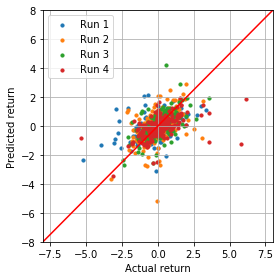

R2:                 0.0728
RMSE:               0.9629
MAE:                0.6142
Explained variance: 0.0728


In [221]:
r2, rmse, expl, mae = evaluation(x, y, metric=ols, alpha=None)

### 3.2 Ridge

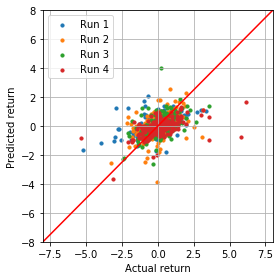

R2:                 0.1756
RMSE:               0.9080
MAE:                0.5959
Explained variance: 0.1756


In [254]:
r2, rmse, expl, mae = evaluation(x, y, metric=ridge, alpha=2.1)

### 3.3 Ridge with different alpha values

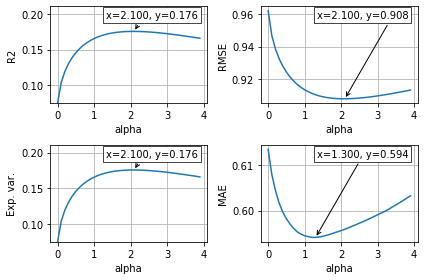

In [299]:
alphas = np.arange(0, 4, 0.1)
plot_alpha_effect(x, y, metric=ridge, alphas=alphas)

### 3.4 Lasso

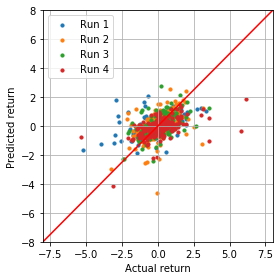

R2:                 0.1859
RMSE:               0.9023
MAE:                0.5819
Explained variance: 0.1859


In [418]:
r2, rmse, expl, mae, coeffs = evaluation(x, y, metric=lasso, alpha=0.002)

### 3.6 Lasso with different alpha values

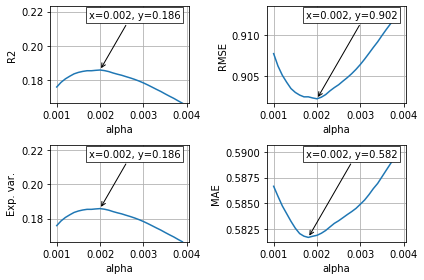

In [300]:
alphas = np.arange(0.001, 0.004, 0.0001)
plot_alpha_effect(x, y, metric=lasso, alphas=alphas)

### 3.7 Lasso most important 25 features

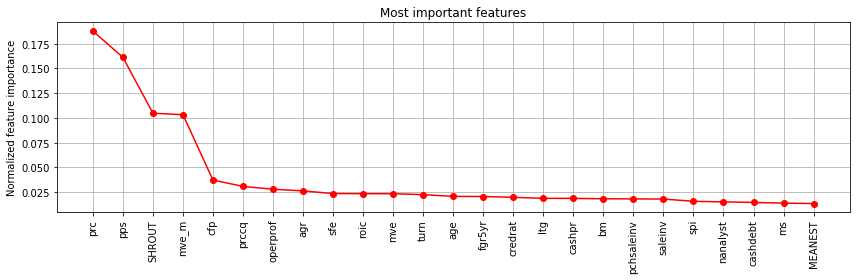

In [434]:
coeff = np.array(coeffs)
coeff = np.abs(coeff).sum(axis=0)
top_25_weights= coeff.argsort()[-25:][::-1]
top25 = np.array([column_names[i] for i in top_25_weights])
top25_values = np.array([coeff[i] for i in top_25_weights])
top25_values_normalized = top25_values/top25_values.sum()
plt.figure(figsize=(12,4))
x_plot = np.arange(0,25,1)
y_plot = top25_values_normalized
plt.plot(x_plot, y_plot, 'r-o')
plt.grid()
plt.xticks(x_plot, top25, rotation=90)
plt.ylabel('Normalized feature importance')
plt.title('Most important features')
plt.tight_layout()

### 3.8 Bayesian Ridge Regression

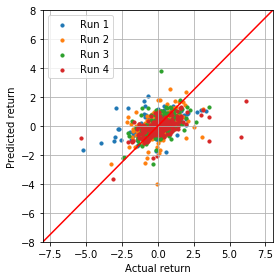

R2:                 0.1766
RMSE:               0.9074
MAE:                0.5957
Explained variance: 0.1766


In [310]:
r2, rmse, expl, mae = evaluation(x, y, metric=bayesianridge, alpha=7.3)

### 3.9 Bayesian Ridge with different alpha values

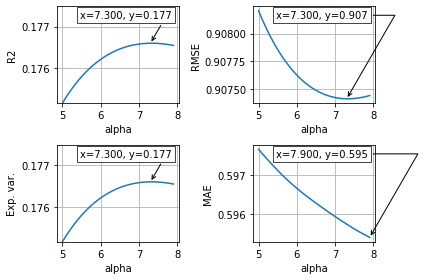

In [309]:
alphas = np.arange(5, 8, 0.1)
plot_alpha_effect(x, y, metric=bayesianridge, alphas=alphas, ratio=1.005)

### 3.10 Stochastic Gradient Descent

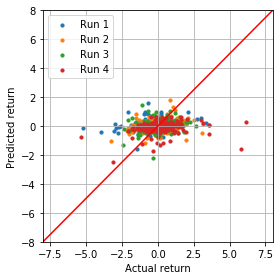

R2:                 0.0150
RMSE:               0.9925
MAE:                0.6738
Explained variance: 0.0150


In [332]:
r2, rmse, expl, mae = evaluation(x, y, metric=sgdregressor, alpha=0.01)

### 3.11 Decision Tree

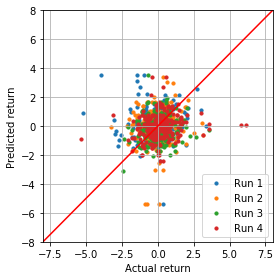

R2:                -0.7584
RMSE:               1.3260
MAE:                0.9321
Explained variance: -0.7578


In [353]:
r2, rmse, expl, mae = evaluation(x, y, metric=decisiontree, alpha=31)

## Part 4: Removing features with low variance

VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by

$$
\begin{aligned}
\mathrm{Var}[X] = p(1 - p)
\end{aligned}
$$

so we can select using the threshold <code>$0.8 * (1-0.8)$</code>.

In [28]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(.99 * (1 - 0.99))
x_vt = sel.fit_transform(x)

### 4.1 OLS

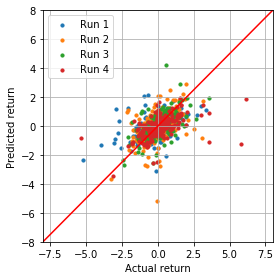

R2:                 0.0725
RMSE:               0.9631
MAE:                0.6142
Explained variance: 0.0725


In [29]:
r2, rmse, expl, mae = evaluation(x_vt, y, metric=ols, alpha=None)

### 4.2 Ridge

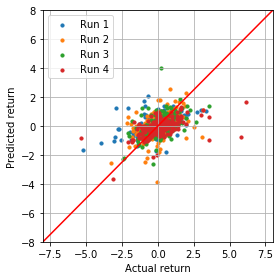

R2:                 0.1756
RMSE:               0.9080
MAE:                0.5959
Explained variance: 0.1756


In [374]:
r2, rmse, expl, mae = evaluation(x_vt, y, metric=ridge, alpha=2.1)

### 4.3 Lasso

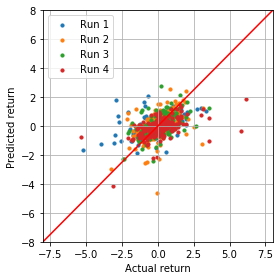

R2:                 0.1859
RMSE:               0.9023
MAE:                0.5819
Explained variance: 0.1859


In [360]:
r2, rmse, expl, mae = evaluation(x_vt, y, metric=lasso, alpha=0.002)

## Part 5: Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a <code>coef_</code> attribute or through a <code>feature_importances_</code> attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

RFECV performs RFE in a cross-validation loop to find the optimal number of features.

### 5.1 OLS

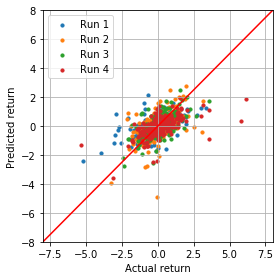

R2:                 0.2783
RMSE:               0.8495
MAE:                0.5621
Explained variance: 0.2783


In [49]:
from sklearn.feature_selection import RFE
rfe_estimator = LinearRegression()
rfe = RFE(estimator=rfe_estimator, n_features_to_select=90, step=1)
rfe.fit(x, y)
ranking = rfe.ranking_
select = rfe.support_
x_rfe = x[:, select]
r2, rmse, expl, mae = evaluation(x_rfe, y, metric=ols, alpha=None)

### 5.2 Influence of number of features selected

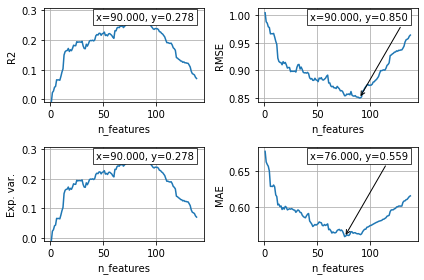

In [388]:
n_features = np.arange(1, 139, 1)
ratio = 1.1
r2s = []
rmses = []
expls = []
maes = []
rfe_estimator = LinearRegression()

for n_feature in n_features:
    rfe = RFE(estimator=rfe_estimator, n_features_to_select=n_feature, step=1)
    rfe.fit(x, y)
    ranking = rfe.ranking_
    select = rfe.support_
    x_rfe = x[:, select]
    r2, rmse, expl, mae = evaluation(x_rfe, y, metric=ols, 
                                     alpha=None, if_plot=False)
    r2s.append(r2)
    rmses.append(rmse)
    expls.append(expl)
    maes.append(mae)


def annot_max(x,y, ax=None):
    y = np.array(y)
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

def annot_min(x,y, ax=None):
    y = np.array(y)
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.96), **kw)

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)
ax1.plot(n_features, r2s)
annot_max(n_features, r2s, ax=ax1)
ax1.set_ylim(np.min(r2s), np.max(r2s)*ratio)
ax1.set_xlabel('n_features')
ax1.set_ylabel('R2')
ax1.grid()

ax2.plot(n_features, rmses)
annot_min(n_features, rmses, ax=ax2)
ax2.set_xlabel('n_features')
ax2.set_ylabel('RMSE')
ax2.grid()

ax3.plot(n_features, expls)
annot_max(n_features, expls, ax=ax3)
ax3.set_ylim(np.min(expls), np.max(expls)*ratio)
ax3.set_xlabel('n_features')
ax3.set_ylabel('Exp. var.')
ax3.grid()

ax4.plot(n_features, maes)
annot_min(n_features, maes, ax=ax4)
ax4.set_xlabel('n_features')
ax4.set_ylabel('MAE')
ax4.grid()

plt.tight_layout()
plt.show();

### 5.3 Ridge

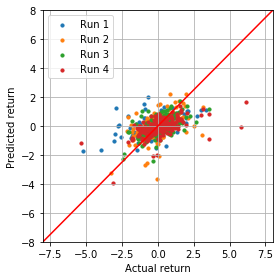

R2:                 0.2536
RMSE:               0.8640
MAE:                0.5694
Explained variance: 0.2536


In [390]:
r2, rmse, expl, mae = evaluation(x_rfe, y, metric=ridge, alpha=2.1)

### 5.4 RFE most important 25 features

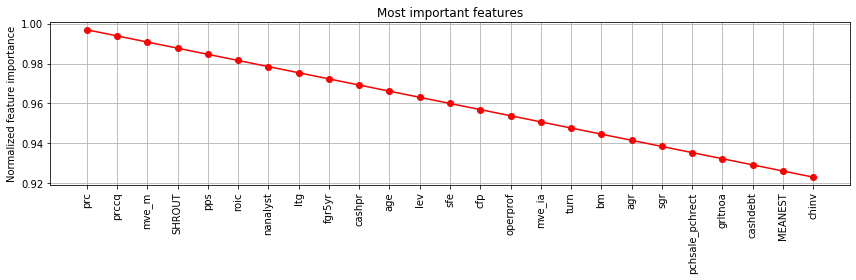

In [48]:
coeff = np.array(ranking)
top_25_weights= coeff.argsort()[:25]
top25 = np.array([column_names[i] for i in top_25_weights])
top25_values = np.array([coeff[i] for i in top_25_weights])
top25_values_normalized = 1-top25_values/top25_values.sum()
plt.figure(figsize=(12,4))
x_plot = np.arange(0,25,1)
y_plot = top25_values_normalized
plt.plot(x_plot, y_plot, 'r-o')
plt.grid()
plt.xticks(x_plot, top25, rotation=90)
plt.ylabel('Normalized feature importance')
plt.title('Most important features')
plt.tight_layout()

### 5.5 Lasso

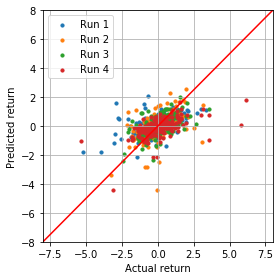

R2:                 0.2419
RMSE:               0.8707
MAE:                0.5639
Explained variance: 0.2419


In [391]:
r2, rmse, expl, mae = evaluation(x_rfe, y, metric=lasso, alpha=0.002)

## Part 6: Principal Component Analysis

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

### 6.1 OLS

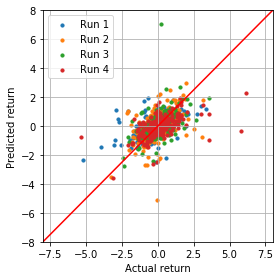

R2:                 0.1391
RMSE:               0.9279
MAE:                0.6010
Explained variance: 0.1391


In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=127)
pca.fit(x)
x_pca = pca.fit_transform(x)
r2, rmse, expl, mae = evaluation(x_pca, y, metric=ols, alpha=None)

### 6.2 Influence of number of PCA components

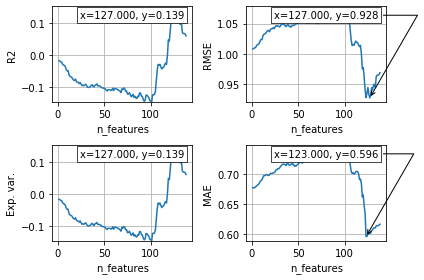

In [398]:
n_features = np.arange(1, 139, 1)
ratio = 1.1
r2s = []
rmses = []
expls = []
maes = []
rfe_estimator = LinearRegression()

for n_feature in n_features:
    pca = PCA(n_components=n_feature)
    pca.fit(x)
    x_pca = pca.fit_transform(x)
    r2, rmse, expl, mae = evaluation(x_pca, y, metric=ols, alpha=None, if_plot=False)

    r2s.append(r2)
    rmses.append(rmse)
    expls.append(expl)
    maes.append(mae)


def annot_max(x,y, ax=None):
    y = np.array(y)
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

def annot_min(x,y, ax=None):
    y = np.array(y)
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.96), **kw)

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)
ax1.plot(n_features, r2s)
annot_max(n_features, r2s, ax=ax1)
ax1.set_ylim(np.min(r2s), np.max(r2s)*ratio)
ax1.set_xlabel('n_features')
ax1.set_ylabel('R2')
ax1.grid()

ax2.plot(n_features, rmses)
annot_min(n_features, rmses, ax=ax2)
ax2.set_xlabel('n_features')
ax2.set_ylabel('RMSE')
ax2.grid()

ax3.plot(n_features, expls)
annot_max(n_features, expls, ax=ax3)
ax3.set_ylim(np.min(expls), np.max(expls)*ratio)
ax3.set_xlabel('n_features')
ax3.set_ylabel('Exp. var.')
ax3.grid()

ax4.plot(n_features, maes)
annot_min(n_features, maes, ax=ax4)
ax4.set_xlabel('n_features')
ax4.set_ylabel('MAE')
ax4.grid()

plt.tight_layout()
plt.show();

### 6.3 Ridge

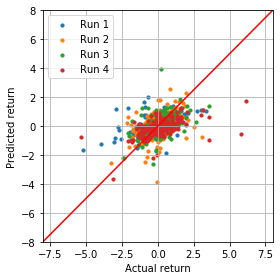

R2:                 0.1837
RMSE:               0.9035
MAE:                0.5937
Explained variance: 0.1837


In [401]:
r2, rmse, expl, mae = evaluation(x_pca, y, metric=ridge, alpha=2.1)

### 6.4 Lasso

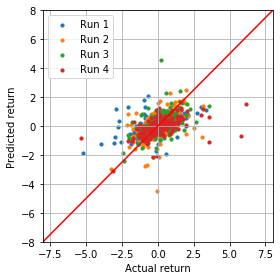

R2:                 0.1945
RMSE:               0.8975
MAE:                0.5795
Explained variance: 0.1945


In [402]:
r2, rmse, expl, mae = evaluation(x_pca, y, metric=lasso, alpha=0.002)

## Part 7: Neural Network

### 7.1 Network structure

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               35840     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 36,097
Trainable params: 36,097
Non-trainable params: 0
_________________________________________________________________


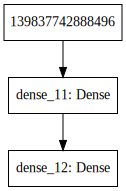

In [11]:
import keras
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
np.random.seed(42)
def regression_1():
    model = Sequential()
    model.add(Dense(256,  activation='relu', kernel_regularizer='l1', input_shape=(139,)))
    model.add(Dense(1, activation = 'linear'))
    return model


model=regression_1()
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 7.2 Training block

In [ ]:
def training_block(x_train, y_train, x_test, model, run):
    weight_name = r'./yujia_{}.h5'.format(run)
    adam = keras.optimizers.Adam(lr=0.0005, decay=1e-6)
    model.compile(loss='mse', optimizer= adam, metrics=['mse'])
#    elstp = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='min')
    checkpoint = ModelCheckpoint(weight_name, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]#,elstp]
    history = model.fit(x_train, y_train, epochs=500, batch_size=1000, validation_split=0.25, callbacks=callbacks_list, verbose=0)
    history_history = history.history
    model.load_weights(weight_name)
    model.compile(loss='mse', optimizer= adam, metrics=['mse'])
    y_pred = model.predict(x_test)
    return y_pred, history_history, model

### 7.3 Train process

In [ ]:
def train(x, y, model):
    x_trains, x_tests, y_trains, y_tests = k_fold(x, y, n_splits=4)
    y_true = []
    y_pred = []
    histories = []
    models = []
    for i in range(len(x_trains)):
        print('Training {} start...'.format(i+1))
        x_train = x_trains[i]
        x_test = x_tests[i]
        y_train = y_trains[i]
        y_test = y_tests[i]
        result = training_block(x_train, y_train, x_test, model, run=i)
        y_pred.append(result[0])
        y_true.append(y_tests[i])
        print('Validation loss: {:.4f}'.format(result[1]['val_loss'][-1]))
        histories.append(result[1])
        models.append(result[2])
    # evaluation
    plot_pred(y_true, y_pred, 'neural network')
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**0.5
    mae = mean_squared_error(y_true, y_pred)
    expl = explained_variance_score(y_true, y_pred)
    print('R2: {:>22.4f}'.format(r2))
    print('RMSE: {:>20.4f}'.format(rmse))
    print('MAE: {:>21.4f}'.format(mae))
    print('Explained variance: {:>4.4f}'.format(expl))
    return histories, r2, rmse, mae, expl, models

### 7.4 Train with all features available

Training 1 start...
Validation loss: 2.2436
Training 2 start...
Validation loss: 2.5226
Training 3 start...
Validation loss: 4.1328
Training 4 start...
Validation loss: 1.9018


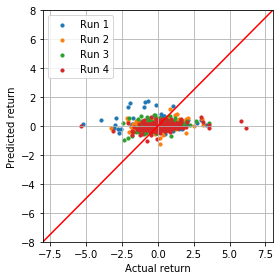

R2:                 0.0133
RMSE:               0.9933
MAE:                0.9867
Explained variance: 0.0162


In [15]:
histories, r2, rmse, mae, expl, models = train(x, y, model=regression_1())

### 7.5 Training and validation loss

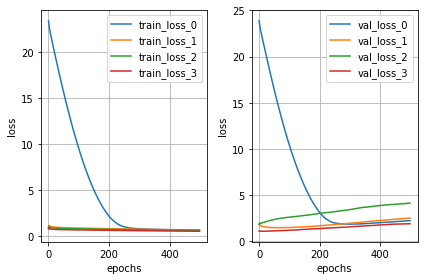

In [16]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
for i in range(len(histories)):
    ax1.plot(histories[i]['loss'], label='train_loss_{}'.format(i))
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()

for i in range(len(histories)):
    ax2.plot(histories[i]['val_loss'], label='val_loss_{}'.format(i))
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show();

### 7.6 Neural network feature importance using connection weights algorithm

From O.M. Ibrahim's paper [<em>A comparison of methods for assessing the relative importance of input variables in
artificial neural networks </em>](https://www.palisade.com/downloads/pdf/academic/DTSpaper110915.pdf), a connection weights (CW) algorithm was mentioned to rank the relative importance of the features to a two layer fully connected network.

The relative importance ($RI_{x}$) of feature $x$ was calculated by:
$$
\begin{aligned}
RI_{x} = \sum_{y=1}^{m} w_{xy} w_{yz},
\end{aligned}
$$
where $\sum_{y=1}^{m} w_{xy} w_{yz}$ is sum of product of final weights of the connection from input neuron to hidden neurons with the connection from hidden neurons to output neuron, $y$ is the total number of hidden neurons, and $z$ is output neurons. 

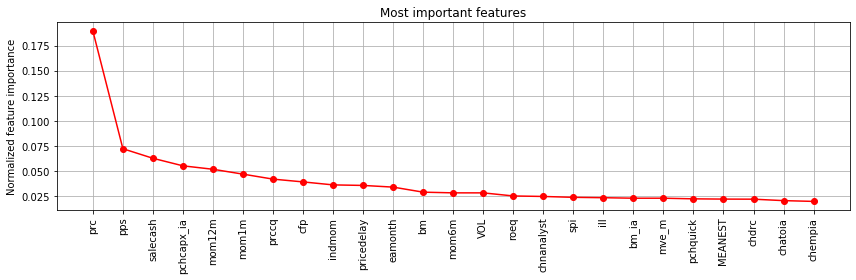

In [26]:
model = models[0]
names = [weight.name for layer in model.layers for weight in layer.weights]
weight_12 = model.get_weights()[0]
weight_23 = model.get_weights()[2]
coeff = np.empty(shape=(weight_12.shape[0],))
for i in range(weight_12.shape[0]):
    temp_coeff = 0
    for j in range(weight_12.shape[1]):
        temp_coeff += weight_12[i,j]*weight_23[j,0]
    coeff[i] = temp_coeff
coeff = np.abs(coeff)
top_25_weights= coeff.argsort()[-25:][::-1]
top25 = np.array([column_names[i] for i in top_25_weights])
top25_values = np.array([coeff[i] for i in top_25_weights])
top25_values_normalized = top25_values/top25_values.sum()
plt.figure(figsize=(12,4))
x_plot = np.arange(0,25,1)
y_plot = top25_values_normalized
plt.plot(x_plot, y_plot, 'r-o')
plt.grid()
plt.xticks(x_plot, top25, rotation=90)
plt.ylabel('Normalized feature importance')
plt.title('Most important features')
plt.tight_layout()

### 7.7 Using features selected by the low variance truncation

Training 1 start...
Validation loss: 2.1162
Training 2 start...
Validation loss: 2.6329
Training 3 start...
Validation loss: 3.5885
Training 4 start...
Validation loss: 1.6216


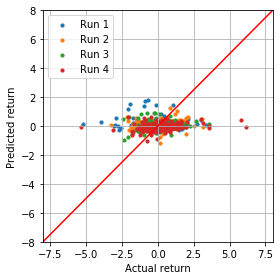

R2:                -0.0083
RMSE:               1.0042
MAE:                1.0083
Explained variance: -0.0059


In [39]:
def regression_2():
    model = Sequential()
    model.add(Dense(256,  activation='relu', kernel_regularizer='l1', input_shape=(134,)))
    model.add(Dense(1, activation = 'linear'))
    return model

histories, r2, rmse, mae, expl, models = train(x_vt, y, model=regression_2())

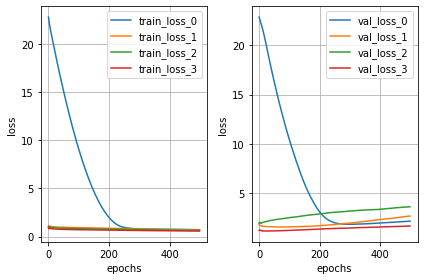

In [40]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
for i in range(len(histories)):
    ax1.plot(histories[i]['loss'], label='train_loss_{}'.format(i))
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()

for i in range(len(histories)):
    ax2.plot(histories[i]['val_loss'], label='val_loss_{}'.format(i))
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show();

### 7.8 Using features selected by recursive feature elimination

Training 1 start...
Validation loss: 1.9826
Training 2 start...
Validation loss: 2.4277
Training 3 start...
Validation loss: 3.9986
Training 4 start...
Validation loss: 1.7990


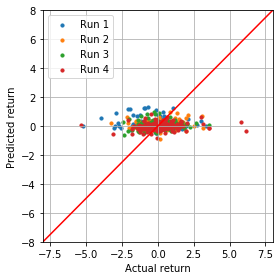

R2:                -0.0303
RMSE:               1.0150
MAE:                1.0303
Explained variance: -0.0272


In [41]:
def regression_3():
    model = Sequential()
    model.add(Dense(256,  activation='relu', kernel_regularizer='l1', input_shape=(90,)))
    model.add(Dense(1, activation = 'linear'))
    return model

histories, r2, rmse, mae, expl, models = train(x_rfe, y, model=regression_3())

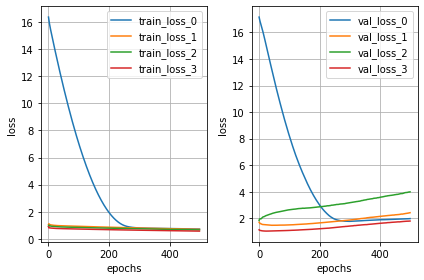

In [42]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
for i in range(len(histories)):
    ax1.plot(histories[i]['loss'], label='train_loss_{}'.format(i))
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()

for i in range(len(histories)):
    ax2.plot(histories[i]['val_loss'], label='val_loss_{}'.format(i))
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show();

### 7.9 Using features from PCA

Training 1 start...
Validation loss: 2.2715
Training 2 start...
Validation loss: 2.1466
Training 3 start...
Validation loss: 4.8063
Training 4 start...
Validation loss: 1.3484


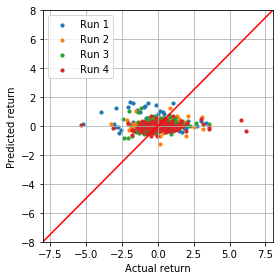

R2:                -0.0683
RMSE:               1.0336
MAE:                1.0683
Explained variance: -0.0644


In [44]:
def regression_4():
    model = Sequential()
    model.add(Dense(256,  activation='relu', kernel_regularizer='l1', input_shape=(127,)))
    model.add(Dense(1, activation = 'linear'))
    return model

histories, r2, rmse, mae, expl, models = train(x_pca, y, model=regression_4())

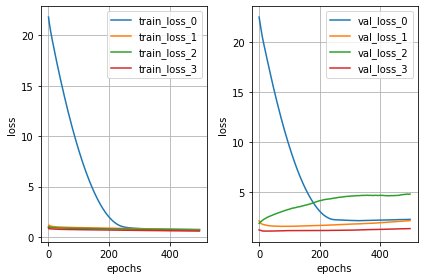

In [45]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
for i in range(len(histories)):
    ax1.plot(histories[i]['loss'], label='train_loss_{}'.format(i))
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()

for i in range(len(histories)):
    ax2.plot(histories[i]['val_loss'], label='val_loss_{}'.format(i))
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show();

## Part 8: Conclusion

The combination of feature selection and regression methods are recursive feature elimation and ordinary least square regression. Surprisingly, the neural networks don't produce a very good result. I hypothesize that the problem is too easy for a neural network. It doesn't mean that neural network is worse than a regression model. Since neural networks are highly nonlinear, therefore it has a lot of local minima. I might be stuck at some local minima that are not global.

The best reuslt I can get is:

|         | R2     | RMSE   | Exp. var. | MAE    |
|---------|--------|--------|-----------|--------|
| RFE+OLS | 0.2783 | 0.8495 | 0.2783    | 0.5621 |

Also, it is interesting to find that the most important features selected by lasso regression, recursive feature elimination and neural network are mostly the same. The features such as PRC, PPS, PRCCQ always have very high weights. PRC means stock price, PPS means price per share, and PRCCQ is end of quarter stock price. Those variables are very important in empirical studies towards stock return, which means our statistical methods and neural network also include empirically important features.